# Model comparison and predictions

This notebook contain the final approach for feature selection and preprocessing. Model selection including HP tuning is also demonstrated here.

Importing essential libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

## Load the data

In [19]:
features = pd.read_csv("./../Training/X_train.csv")
labels = pd.read_csv("./../Training/y_train.csv")

sanity check

In [20]:
print(f"The shape of training feature matrix is {features.shape}")
print(f"The shape of training labels is {labels.shape}")

The shape of training feature matrix is (33050, 44)
The shape of training labels is (33050, 2)


sanity check

In [21]:
#Sanity check to see if the rows in X and y corresponds to the same entities
assert (features["Unique_ID"] == labels["Unique_ID"]).all()

## Train Test split

We need to set aside a portion of our training data to perform evaluations for selecting the best model. It is best to do it in the outset itself to avoid any data leakage or bias

In [22]:
y = labels["Dependent_Variable"]
X = features.drop("Unique_ID", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y) # Random state is set to ensure reproducibility

In [23]:
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print()
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (26440, 43)
The shape of y_train is (26440,)

The shape of X_test is (6610, 43)
The shape of y_test is (6610,)


## Cross validation scheme

We use stratified shuffle spit strategy to partition our training data for training and evaluation. This strategy is used to ensure all folds contain data representitive of the full distribution

In [24]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

## Preprocessing

* There are categorical and numerical features in the datset.

* Highly correlated features are removed - (N5 - N8,  N20 & N27)

* Features with more than 80% of their values missing are also removed -(N25 - N32).

* Remaining Categorical features are one hot encoded

* Numerical features have missing values. Simple strategy of using mean value of the feature in the place of missing value is used to handle missing values. The values are then scaled to ensure all features lie in a similar numerical range.

* Pipelines are used for all preprocessing steps. This ensure that mistakes are not introduced and data leakage doesn't occur.


In [25]:
# Categorical features
cat_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Numerical features -> N5 - N8 & N20, N27 removed because of high correlation. 
#                       N25 - N32 removed due to large number of missing values

num_features = ['N1', 'N2', 'N3', 'N4', 'N9', 'N10', 'N10.1', 'N11', 
                'N12', 'N14','N15','N16', 'N17', 'N18', 'N19', 'N20',
                 'N21', 'N22', 'N23', 'N24', 'N33', 'N34','N35']

Preprocessing is left the same as before

In [26]:
## Pipeline for categorical features

# select the categorical features from the input
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])

#OneHot encoding
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
                            ])

## Pipeline for numerical featurees

# select the numerical variables                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])

# Imputing for missing values, Scaling
num_transformers = Pipeline([('selector', select_num_features),
                            ('imputer', SimpleImputer()),
                            ('scaler', MinMaxScaler()),
                            ])

## combining both pipelines
preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [27]:
preprocess_pipe

FeatureUnion(transformer_list=[('cat',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_cat',
                                                                                  'passthrough',
                                                                                  ['C1',
                                                                                   'C2',
                                                                                   'C3',
                                                                                   'C4',
                                                                                   'C5',
                                                                                   'C6',
                                                                                   'C7',
                                                                                   'C8'])])),
                                                ('onehot',
                                                 OneHotEncoder(handle_unknown='infrequent_if_exist'))])),
                               ('num',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_num',
                                                                                  'passthrough',
                                                                                  ['N1',
                                                                                   'N2',
                                                                                   'N3',
                                                                                   'N4',
                                                                                   'N9',
                                                                                   'N10',
                                                                                   'N10.1',
                                                                                   'N11',
                                                                                   'N12',
                                                                                   'N14',
                                                                                   'N15',
                                                                                   'N16',
                                                                                   'N17',
                                                                                   'N18',
                                                                                   'N19',
                                                                                   'N20',
                                                                                   'N21',
                                                                                   'N22',
                                                                                   'N23',
                                                                                   'N24',
                                                                                   'N33',
                                                                                   'N34',
                                                                                   'N35'])])),
                                                ('imputer', SimpleImputer()),
                                                ('scaler', MinMaxScaler())]))])

## List of models

Since AUC-ROC is our metric of choice, we need a model which will give probability estimates. We will train the following models and compare their performance.

1. Logistic regression
2. Decision Tree
3. Random Forest
4. XGBoost
5. Gradient Boosting(Sklearn implemetation)

In [28]:
# A list of dictionaries where each dictionary corresponds to a model family. Each model need a name, an instance of its estimator and parameter grid to tune hyperparameters with GridSearchCV
model_list = [{"name": "Logistic Regression",
                "model": LogisticRegression(max_iter=2000, solver = 'saga', random_state=42),
                "param_grid": {"model__C": [0.001, 0.1, 1, 10, 100],
                                "model__penalty": ['l1', 'l2']}
            },

            {"name": "Decision tree",
            "model": DecisionTreeClassifier(random_state=42),
            "param_grid": {"model__max_depth": [5, 10, 15, 20],
                            "model__min_samples_split": range(2, 10, 2),
                            "model__min_samples_leaf": range(1, 5)}
            },
            
            {"name": "Random Forest",
            "model": RandomForestClassifier(random_state=42),
            "param_grid": { "model__min_samples_split":[4,8,10,12], 
                            "model__n_estimators":[300, 350, 400, 500]}
            },

            {"name": "XGBoost",
            "model": XGBClassifier(random_state=42),
            "param_grid": {"model__max_depth": [5, 10, 15, 20, None],
                            "model__n_estimators": [100, 200, 300]}
            },

            {"name": "Gradient boosting trees",
            "model": GradientBoostingClassifier(random_state=42),
            "param_grid": {"model__learning_rate": [1e-3, 1e-2, 1e-1],
                            "model__n_estimators": [100, 200, 300]}
            }


        ]

## Model training, Hyper parameter tuning and evaluation

### Helper functions for training and evaluation

Four functions are defined here to help train, tune, evaluate and compare models. This will help get rid of a lot of boiler plate code and help automate repeated tasks.

In [29]:
def train_model(model, X_train, y_train, cv=5):
    '''Trains the  model
    Args:
        model: Instance of the model to train
        X_train: Training data feature matrix
        y_train: Training data label vector
        cv: Cross validation Scheme
        
    Returns:
        trained model
        cv_results
    '''

    
    cv_results = cross_validate(model, X_train, y_train,
                                cv=cv,
                                scoring='roc_auc', 
                                return_train_score=True)

    mean_train_score = cv_results["train_score"].mean()
    mean_val_score = cv_results["test_score"].mean()
    
    std_train_score = cv_results["train_score"].std()
    std_val_score = cv_results["test_score"].std()

    print(f"Cross validated training results for the model")
    print(f"Train score: {mean_train_score} +/- {std_train_score}" )
    print(f"Validation score: {mean_val_score} +/- {std_val_score}" )

    trained_model = model.fit(X_train, y_train)

    return trained_model, cv_results

def evaluate_model(model, X_test, y_test):

    '''Evaluates the  model
    Args:
        fitted_model: Instance of the model to train
        X_test: Test data feature matrix
        y_test: Test data label vector
        
    Returns:
        metrics: A dictionary containing auc_roc score, accuracy, fpr and tpr
    '''
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    print("AUC-ROC score on test set: ", auc)
    print("Accuracy score on test set: ", acc)
    metrics = {"auc_roc": auc, "accuracy": acc, "fpr": fpr, "tpr": tpr}
    
    return metrics

def tune_model(model, param_grid, cv=5):
    '''Do hyper parameter tuning using GridSearch strategy
    
        Args:
            model: Model to be tuned
            param_grid: dict of parameters
            X_train: Feature matrix
            y_train: Label matrix
        
        Returns: 
            best parameters
            best estimator
        '''

    search = GridSearchCV(model, param_grid = param_grid,
                        cv = cv,
                        scoring='roc_auc',
                        return_train_score=True)
    
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    cv_results = search.cv_results_
    
    print("Best parameters: ", search.best_params_)
    
    print("-------------------Best model performance --------------------------")
    
    mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
    mean_val_score = search.cv_results_['mean_test_score'][search.best_index_]
    std_train_score = search.cv_results_['std_train_score'][search.best_index_]
    std_val_score = search.cv_results_['std_test_score'][search.best_index_]

    print(f"Score of the model on the train set:\n"
         f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

    print(f"Score of the model on the validation set:\n"
        f"{mean_val_score:.3f} +/- {std_val_score:.6f}")
    
    
    
    return best_model, cv_results

def compare_models(model_list, preprocess_pipe, cv):
    '''Compare a list of models defined in model_list and return the auc, fpr and tpr
        Args:
            model_list: List of models to compare. Must be a list of dictionaries with keys;
                            name - name of the model
                            model - an instance of the estimator,
                            param_grid - hyper parameter grid for hp tuning with gridsearch

            preprocess_pipe: Pipeline object for preprocessing
            cv: cross validation scheme

        Returns:
            logged_metrics: A dictionary with model names as keys
    '''
    logged_metrics = {}
    for model in model_list:
        model_name = model["name"]
        print(f"Training {model_name} model...")
        model_pipe = Pipeline([('preprocess', preprocess_pipe),
                                ('model', model["model"])])
        
        print(f"Tuning hyper parameters...")
        
        param_grid = model["param_grid"]
        tuned_model, _ = tune_model(model_pipe, param_grid, cv=cv)
        metrics = evaluate_model(tuned_model, X_test, y_test)

        #store metrics for later use
        logged_metrics[model_name] = metrics
        print()

    return logged_metrics


Let's train and compare models

In [30]:
logged_metrics = compare_models(model_list, preprocess_pipe, cv)

Training Logistic Regression model...
Tuning hyper parameters...
Best parameters:  {'model__C': 10, 'model__penalty': 'l1'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.767 +/- 0.000462
Score of the model on the validation set:
0.757 +/- 0.002839
AUC-ROC score on test set:  0.7581507311967224
Accuracy score on test set:  0.7405446293494705

Training Decision tree model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.727 +/- 0.001118
Score of the model on the validation set:
0.713 +/- 0.003249
AUC-ROC score on test set:  0.711410021029821
Accuracy score on test set:  0.7190620272314675

Training Random Forest model...
Tuning hyper parameters...
Best parameters:  {'model__min_samples_split': 8, 'model__n_estimators': 500}
--------------

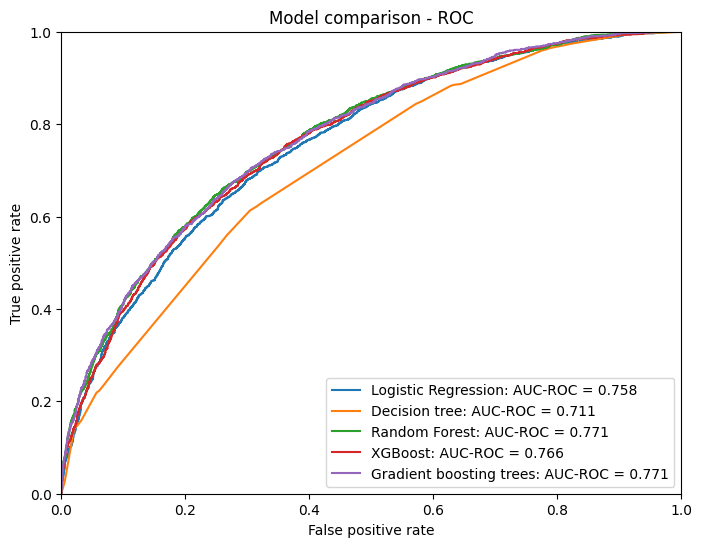

In [32]:
def plot_roc_comparison(logged_metrics, title):
    '''Function to draw roc curves for multiple models in a single plot'''
    
    plt.figure(figsize=(8, 6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    for model in logged_metrics.keys():
        metrics = logged_metrics[model]
        auc = metrics["auc_roc"]
        label = f"{model}: AUC-ROC = {auc:.3f}"
        plt.plot(metrics["fpr"], metrics["tpr"], label=label)

    plt.title(title)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    plt.show()

plot_roc_comparison(logged_metrics, "Model comparison - ROC")

Both Random forest and gradient boost model seems to perform best with AUC-ROC of 0.771. We can choose either for final predictions. I am choosing Gradient boost since it is said to be more stable(at least theoretically.)

## Retraining the best model on the entire training data

In [34]:
train_features = pd.read_csv("./../Training/X_train.csv")
train_labels = pd.read_csv("./../Training/y_train.csv")

test_features = pd.read_csv("./../Test/X_test.csv")

In [35]:
y_train = train_labels["Dependent_Variable"]
X_train = train_features.drop("Unique_ID", axis=1)

test_ID = test_features["Unique_ID"]
X_test = test_features.drop("Unique_ID", axis=1)

In [37]:
gradient_boost_pipe = Pipeline([('preprocess', preprocess_pipe),
                                ('model', GradientBoostingClassifier(n_estimators=300, 
                                                                    learning_rate=0.1, 
                                                                    random_state=42))])

In [38]:
gradient_boost_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('select_cat',
                                                                                                   'passthrough',
                                                                                                   ['C1',
                                                                                                    'C2',
                                                                                                    'C3',
                                                                                                    'C4',
                                                                                                    'C5',
                                                                                                    'C6',
                                                                                                    'C7',
                                                                                                    'C8'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('select_num',
                                                                                                   'passthrough',
                                                                                                   ['N1',
                                                                                                    'N2',
                                                                                                    'N3',
                                                                                                    'N4',
                                                                                                    'N9',
                                                                                                    'N10',
                                                                                                    'N10.1',
                                                                                                    'N11',
                                                                                                    'N12',
                                                                                                    'N14',
                                                                                                    'N15',
                                                                                                    'N16',
                                                                                                    'N17',
                                                                                                    'N18',
                                                                                                    'N19',
                                                                                                    'N20',
                                                                                                    'N21',
                                                                                                    'N22',
                                                                                                    'N23',
                                                                                                    'N24',
                                                          

## Final prediction

In [39]:
y_scores = gradient_boost_pipe.predict_proba(X_test)[:, 1]

In [40]:
result_df = pd.DataFrame({"Unique_ID": test_ID, "Class_1_Probability": y_scores})

In [41]:
result_df.to_csv("./../Test/final_predictions.csv", index=False)